# Detect anomalies
Find all the points, where ambient temperature sensors could show temperature out of normal performance.
Prepare the final dataset for modeling.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
import seaborn as sns
from mpl_toolkits import mplot3d
import datetime

In [2]:
# Load dataset with all the sensors
df = pd.read_csv("../data/processed/data_5min_single_lamps_single_sensors.csv", parse_dates=["time"]).drop(labels = ['Unnamed: 0'], axis = 1)
pf = pd.read_csv('../data/processed/lamp_to_sensor_table_raw.csv')

In [3]:
# Convert matching lamps and senors to a dictionary
dict_lamp_sen = dict(zip(pf.source_address, pf.source_address_external))


In [4]:
lamps = list(pf['source_address'].unique())
sensors = list(pf['source_address_external'].unique())


In [5]:
# Create df used for visualization
df_vis = df.copy()
df_vis['roll_avg'] = df_vis['shtc3_temperature'] # just to initiate a column for plotting later rolling average


In [6]:
# Remove some lamps, where sensors repeat, to have unique ones
lamps.remove(2050868026)
lamps.remove(730804714)

In [7]:
# map lamp with sensor from the dictionary
df_vis['source_address_external'] = df_vis['source_address'].map(dict_lamp_sen)

In [8]:
df_vis.head()

,source_address,time,light_state,local_detections,sht40_humidity,sht40_temperature,shtc3_humidity,shtc3_temperature,total_normalized_energy,wsen_pads_temperature,delta_energy,roll_avg,source_address_external
0,2062404276,2022-08-15 00:00:00,2.0,18565.0,26.09,34.87,48.59,22.06,189624.0,35.84,0.0,22.06,1916751226
1,2062404276,2022-08-15 00:05:00,2.0,18565.0,26.09,34.85,48.60,22.06,189624.0,35.81,0.0,22.06,1916751226
2,2062404276,2022-08-15 00:10:00,2.0,18565.0,26.02,34.82,48.60,22.04,189624.0,35.80,0.0,22.04,1916751226
3,2062404276,2022-08-15 00:15:00,2.0,18565.0,26.09,34.83,48.64,22.03,189624.0,35.78,0.0,22.03,1916751226
4,2062404276,2022-08-15 00:20:00,2.0,18565.0,26.02,34.86,48.64,22.07,189624.0,35.78,0.0,22.07,1916751226


In [9]:
# Remove these lamps from df and add the sensor address
df_vis = df_vis[~(df_vis['source_address'].isin([2050868026, 730804714]))].copy()


In [10]:
# Calculate the mean
df_vis.reset_index(inplace = True)
df_vis['avg_temp_sen'] = 0 # initialize column
df_vis['avg_temp_sen_std'] = 0 # initialize column

In [11]:
df_vis.set_index('time', inplace = True)

In [12]:
# Calculate std of avg temp of a sensor
m = len(sensors) - 1
df_vis.at[pd.Timestamp('2022-08-15 00:05:00'),'avg_temp_sen_std'] = np.sqrt(np.power((df_vis.at[pd.Timestamp('2022-08-15 00:05:00') ,'shtc3_temperature'] - df_vis.at[pd.Timestamp('2022-08-15 00:05:00') ,'avg_temp_sen']).values, 2)/m)

In [13]:
# Takes long time!
# Change it
for time in df_vis.index:
    df_vis.at[time ,'avg_temp_sen'] = df_vis.at[time ,'shtc3_temperature'].values.mean()
    df_vis.at[time ,'avg_temp_sen_std'] = np.std(df_vis.at[time ,'shtc3_temperature'].values,  ddof=1)

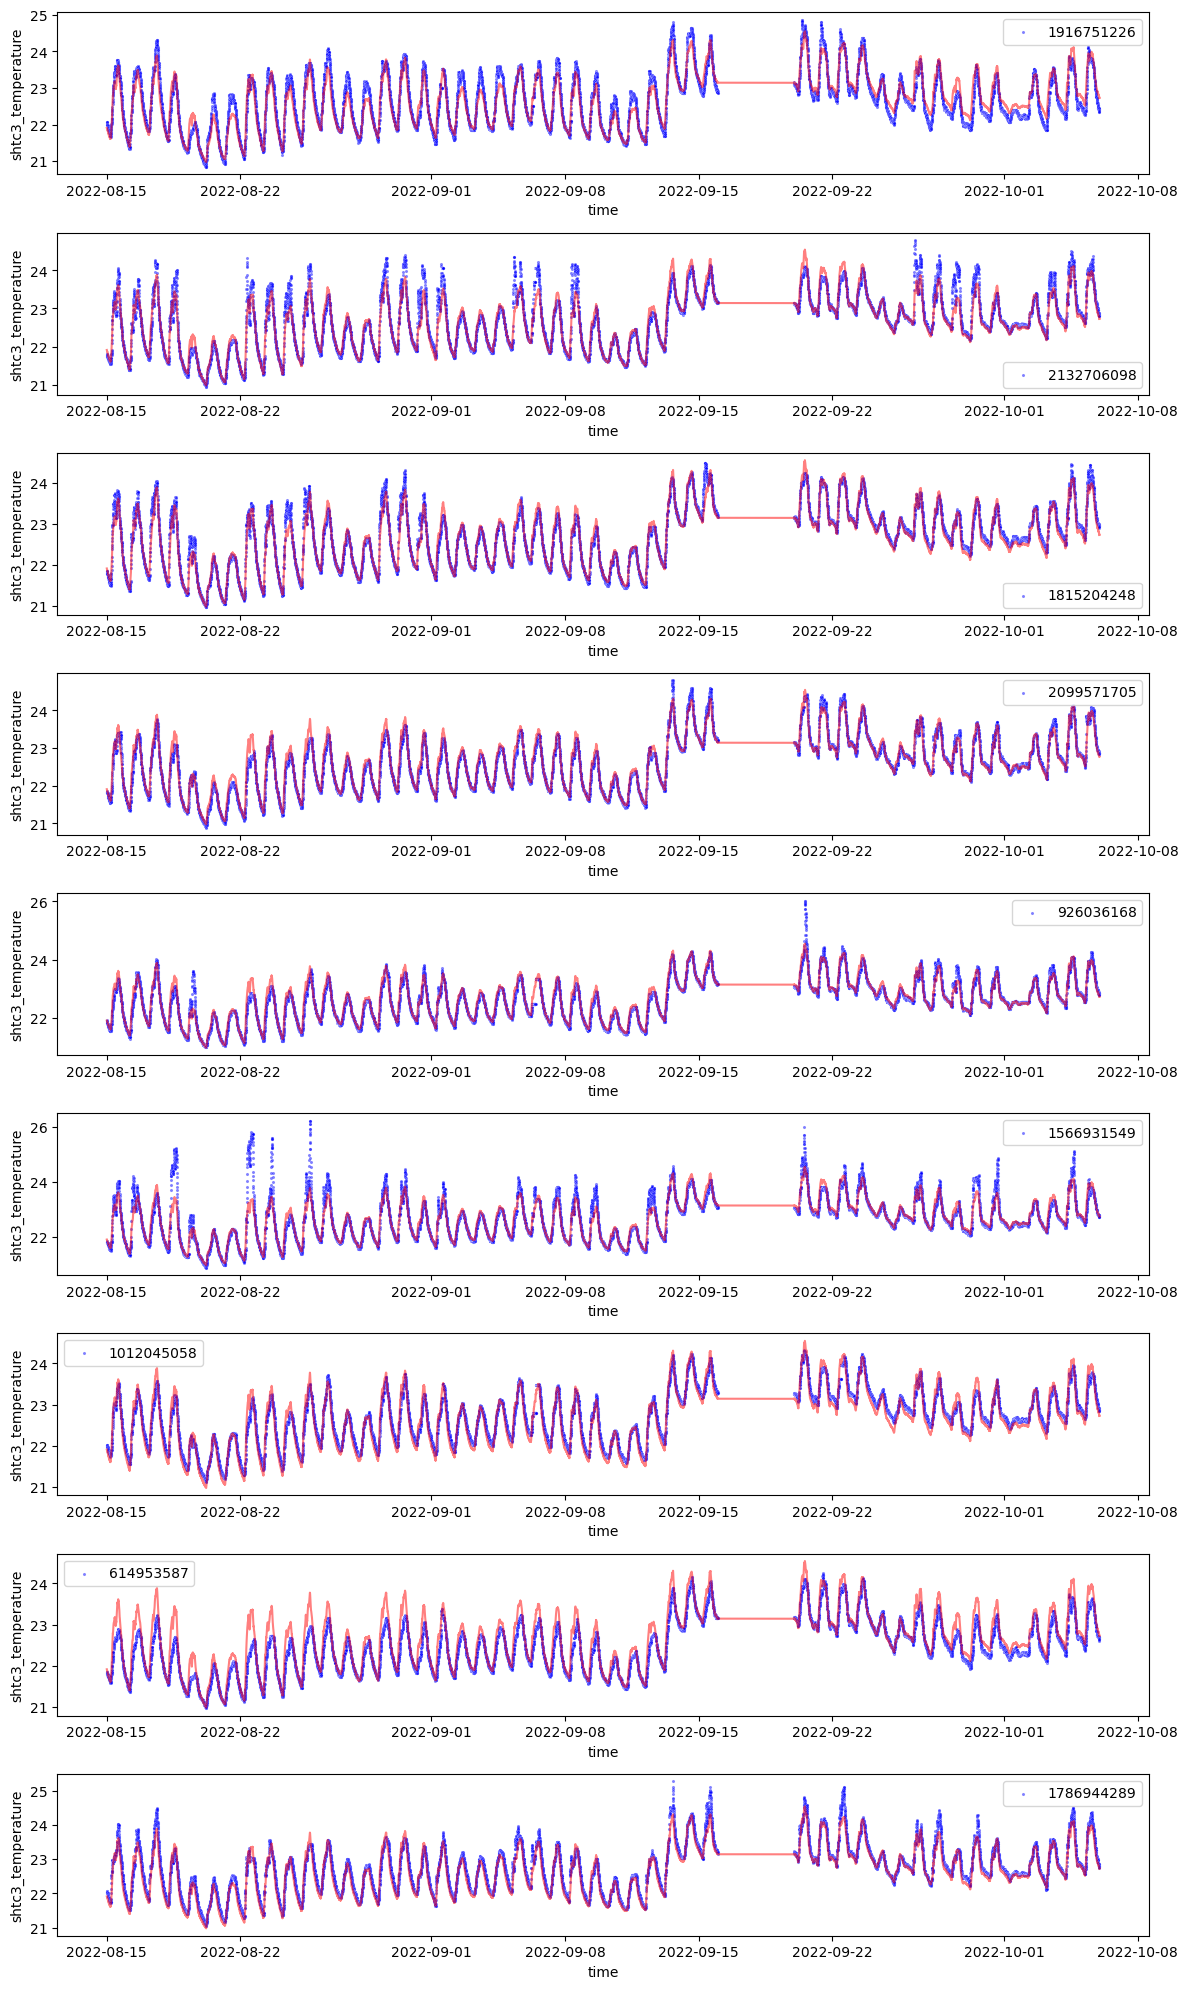

In [37]:
# Plot sensor data (blue), together with the average (red)
df_vis.reset_index(inplace = True)
df_vis.set_index(['source_address', 'time'], inplace = True)

size = 5
fig, axes = plt.subplots(len(lamps), 1)
fig.set_figheight(20)
fig.set_figwidth(12)

for i in range(len(lamps)):
    df_vis.at[lamps[i] ,'roll_avg'] = df_vis['shtc3_temperature'].rolling(700).mean()
    sns.scatterplot(ax = axes[i],data = df_vis.loc[lamps[i]], x='time', y='shtc3_temperature', s=size, alpha=.5, color = 'blue', label = df_vis.loc[lamps[i]]['source_address_external'].iloc[0]);
    # sns.lineplot(ax = axes[i],  x = 'time',
    #          y = 'roll_avg',
    #          data = df_vis.loc[lamps[i]], color = 'black');
    sns.lineplot(ax = axes[i],  x = 'time',
             y = 'avg_temp_sen',
             data = df_vis.loc[lamps[i]], color = 'red', alpha = 0.5)
    
    
plt.tight_layout()  
plt.show()

In [15]:
# Remove points, which are further away from the mean than num of std
num = 1.5 # number of std which we want to include

df_vis.head()
df_vis_clean = df_vis[(df_vis['shtc3_temperature'] < (df_vis['avg_temp_sen'] + num * df_vis['avg_temp_sen_std'])) ]
df_vis_clean = df_vis_clean[(df_vis_clean['shtc3_temperature'] > (df_vis_clean['avg_temp_sen'] - num * df_vis_clean['avg_temp_sen_std']))]

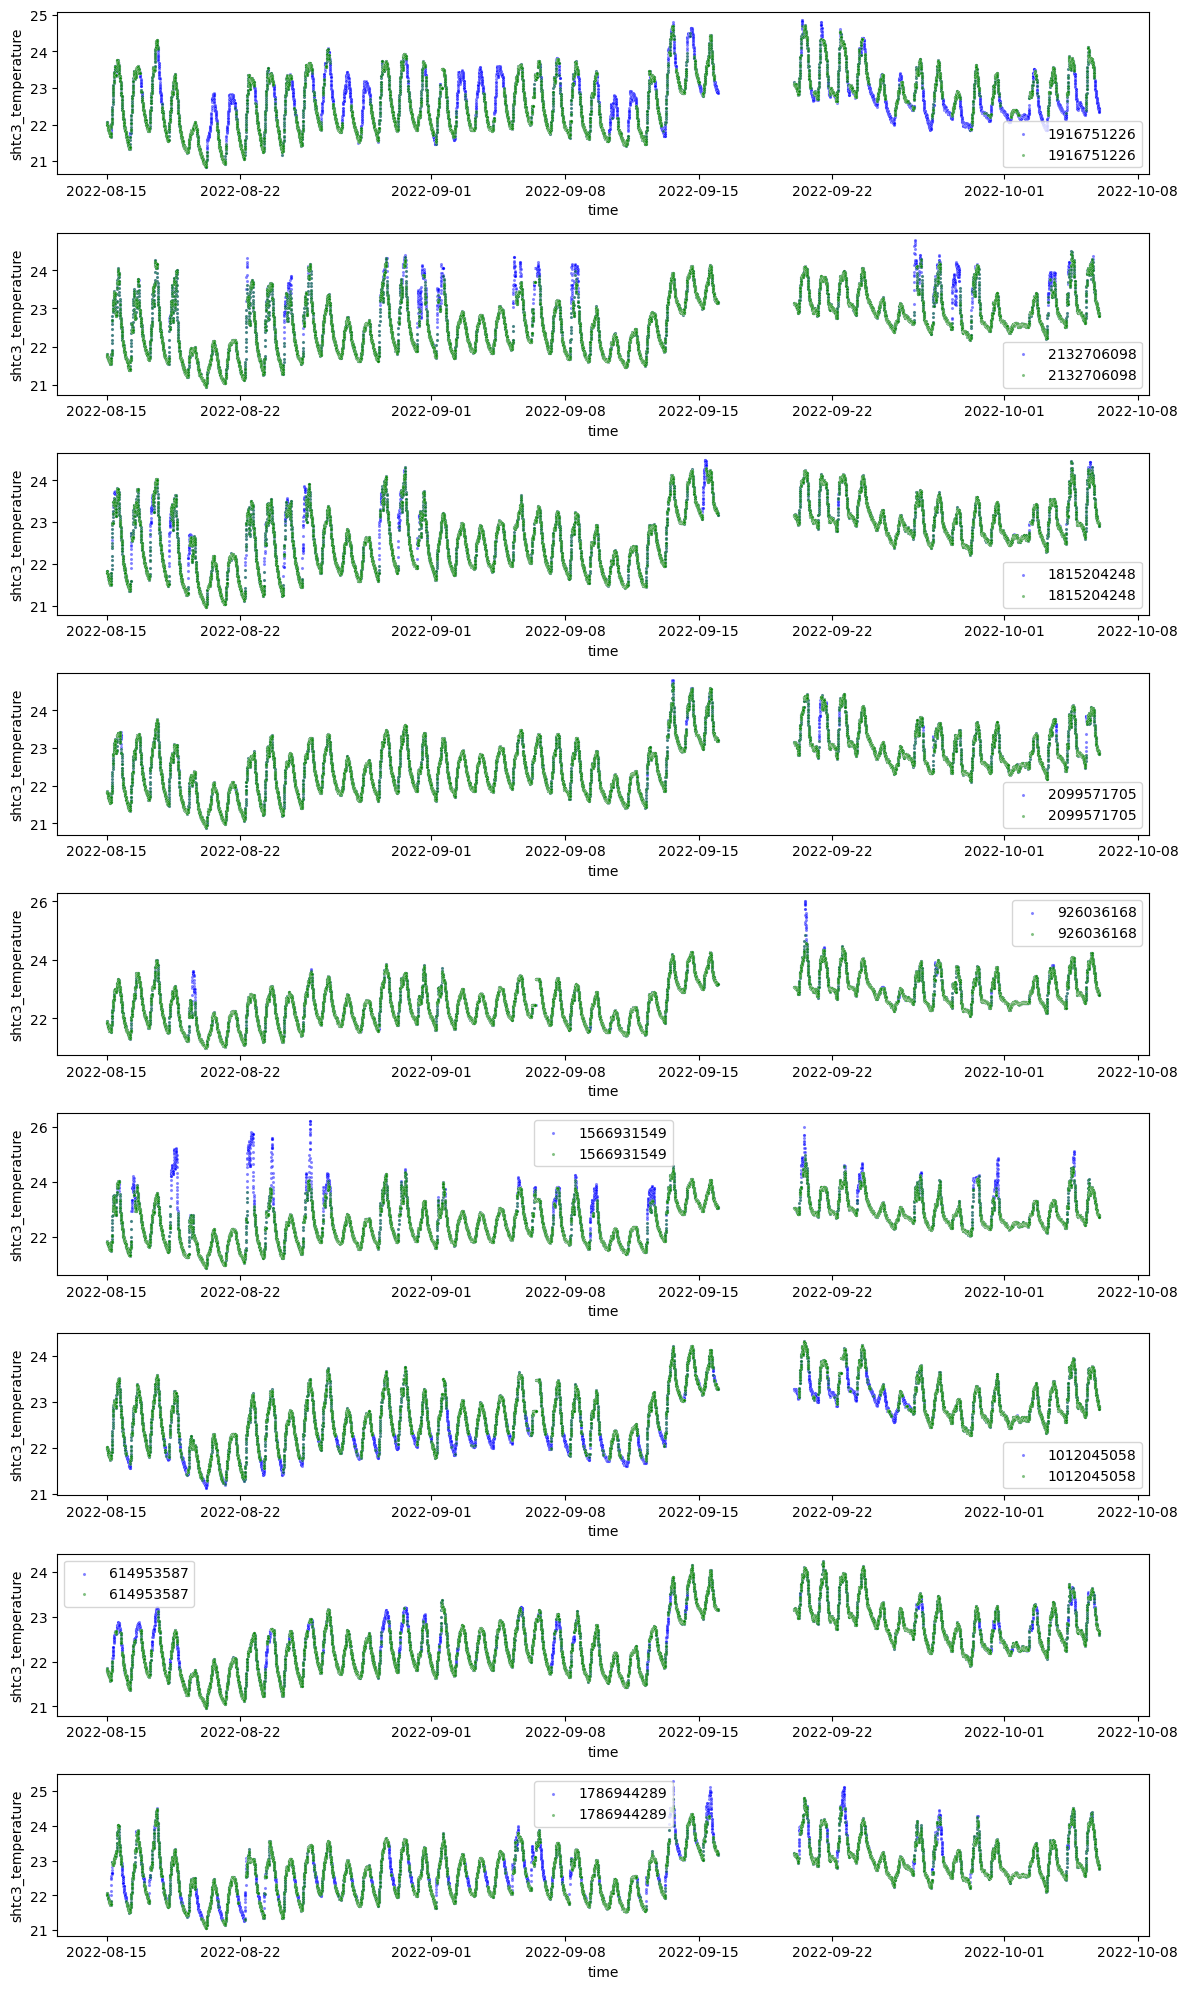

In [16]:
# Plot; blue - all sensor data, green are within num* std from the mean
df_vis.reset_index(inplace = True)
df_vis.set_index(['source_address', 'time'], inplace = True)

size = 5
fig, axes = plt.subplots(len(lamps), 1)
fig.set_figheight(20)
fig.set_figwidth(12)

for i in range(len(lamps)):
    df_vis.at[lamps[i] ,'roll_avg'] = df_vis['shtc3_temperature'].rolling(700).mean()
    sns.scatterplot(ax = axes[i],data = df_vis.loc[lamps[i]], x='time', y='shtc3_temperature', s=size, alpha=.5, color = 'blue', label = df_vis.loc[lamps[i]]['source_address_external'].iloc[0]);
    sns.scatterplot(ax = axes[i],data = df_vis_clean.loc[lamps[i]], x='time', y='shtc3_temperature', s=size, alpha=.5, color = 'green', label = df_vis.loc[lamps[i]]['source_address_external'].iloc[0]);
    
    
plt.tight_layout()  
plt.show()

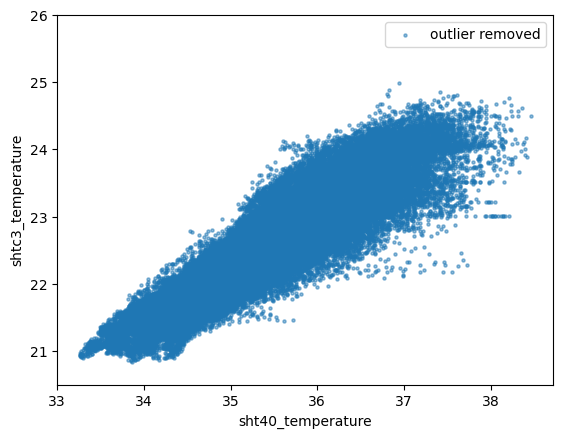

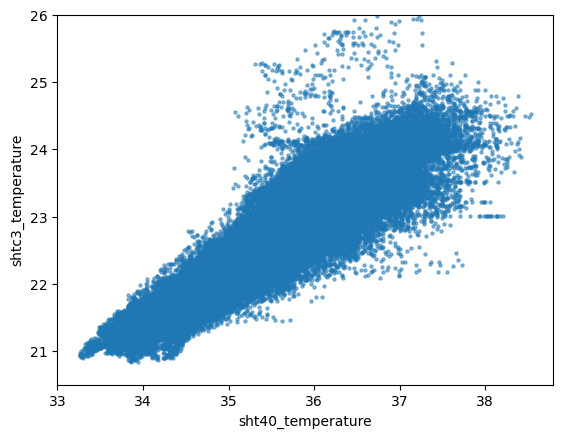

In [39]:
# Plot to look how the spread of the points have changed
df_vis_clean.plot.scatter(x='sht40_temperature', y='shtc3_temperature', s=size, alpha=.5, ylim = (20.5, 26), label = 'outliers removed');
df_vis.plot.scatter(x='sht40_temperature', y='shtc3_temperature', s=size, alpha=.5, ylim = (20.5, 26), label = 'all the data');

## Create dataset with average over sensors and single lamps

 Dataset which is clean : ds_vis_clean --> remove num * std daviations ; here 1.5



In [19]:
df_clean = df_vis_clean.reset_index().drop(labels = ['index', 'roll_avg', 'avg_temp_sen',  'avg_temp_sen_std'], axis = 1).copy()

In [22]:
# Create a table with average temperature & humidity of all the sesnors from the cleaned dataset
df_avg_clean = df_clean.groupby('time').agg('mean')
df_avg_clean.head()

,source_address,light_state,local_detections,sht40_humidity,sht40_temperature,shtc3_humidity,shtc3_temperature,total_normalized_energy,wsen_pads_temperature,delta_energy,source_address_external
time,,,,,,,,,,,
2022-08-15 00:00:00,9.039812e+08,2.0,17797.333333,26.017778,34.607778,49.495556,21.908889,201540.111111,35.022222,0.0,1.541238e+09
2022-08-15 00:05:00,9.039812e+08,2.0,17797.333333,26.047778,34.594444,49.500000,21.902222,201540.111111,35.011111,0.0,1.541238e+09
2022-08-15 00:10:00,9.039812e+08,2.0,17797.333333,25.994444,34.594444,49.501111,21.901111,201540.111111,35.005556,0.0,1.541238e+09
2022-08-15 00:15:00,9.039812e+08,2.0,17797.333333,26.063333,34.587778,49.528889,21.896667,201540.111111,34.997778,0.0,1.541238e+09
2022-08-15 00:20:00,7.591783e+08,2.0,17701.375000,26.021250,34.541250,49.642500,21.867500,203029.625000,34.891250,0.0,1.494299e+09


In [23]:
df_avg_clean.reset_index()
df_clean.set_index(['source_address', 'time'], inplace = True)

In [26]:
df.set_index(['source_address', 'time'], inplace = True)

In [40]:
# Creating data frame with average sensors, but single lamps
df_clean_final  = pd.DataFrame(columns=df.reset_index().columns)
df_clean_final .set_index(['source_address', 'time'], inplace=True)


for address in list(df.reset_index()['source_address'].unique()):
# take a subset of df with only lamps
    df_lamp = df.xs(address, level=0, drop_level = False).copy()
# add colums from sensor data to the lamp data
    df_lamp.drop(labels = ['shtc3_temperature', 'shtc3_humidity'], axis =1, inplace = True)
    df_lamp.reset_index('source_address', inplace = True)
#     # sub_sensor_only.reset_index('source_address',inplace = True)
    df_lamp = df_lamp.join(df_avg_clean[['shtc3_temperature', 'shtc3_humidity']])
# remove rows with no values (NaN) of real temperature 
    df_lamp = df_lamp[df_lamp['shtc3_temperature'].notna()]
    df_lamp.reset_index(inplace = True)
    df_lamp.set_index(['source_address', 'time'], inplace=True)

    
    df_clean_final = pd.concat([df_clean_final,df_lamp])
    

light_state  local_detections  \
source_address time                                                 
856134660      2022-08-15 00:00:00          2.0           13815.0   
               2022-08-15 00:05:00          2.0           13815.0   
               2022-08-15 00:10:00          2.0           13815.0   
               2022-08-15 00:15:00          2.0           13815.0   
               2022-08-15 00:20:00          2.0           13815.0   
...                                         ...               ...   
               2022-10-05 23:35:00          2.0           20367.0   
               2022-10-05 23:40:00          2.0           20367.0   
               2022-10-05 23:45:00          2.0           20367.0   
               2022-10-05 23:50:00          2.0           20367.0   
               2022-10-05 23:55:00          2.0           20367.0   

                                    sht40_humidity  sht40_temperature  \
source_address time                                                     
856134660      2022-08-15 00:00:00           25.86              34.49   
               2022-08-15 00:05:00           25.79              34.49   
               2022-08-15 00:10:00           25.73              34.47   
               2022-08-15 00:15:00           25.92              34.39   
               2022-08-15 00:20:00           25.65              34.39   
...                                            ...                ...   
               2022-10-05 23:35:00           23.73              35.84   
               2022-10-05 23:40:00           23.86              35.84   
               2022-10-05 23:45:00           23.72              35.78   
               2022-10-05 23:50:00           23.86              35.83   
               2022-10-05 23:55:00           23.66              35.82   

                                    total_normalized_energy  \
source_address time                                           
856134660      2022-08-15 00:00:00                 173679.0   
               2022-08-15 00:05:00                 173679.0   
               2022-08-15 00:10:00                 173679.0   
               2022-08-15 00:15:00                 173679.0   
               2022-08-15 00:20:00                 173679.0   
...                                                     ...   
               2022-10-05 23:35:00                 254184.0   
               2022-10-05 23:40:00                 254192.0   
               2022-10-05 23:45:00                 254192.0   
               2022-10-05 23:50:00                 254192.0   
               2022-10-05 23:55:00                 254192.0   

                                    wsen_pads_temperature  delta_energy  \
source_address time                                                       
856134660      2022-08-15 00:00:00                  34.71           0.0   
               2022-08-15 00:05:00                  34.70           0.0   
               2022-08-15 00:10:00                  34.69           0.0   
               2022-08-15 00:15:00                  34.68           0.0   
               2022-08-15 00:20:00                  34.68           0.0   
...                                                   ...           ...   
               2022-10-05 23:35:00                  36.05           0.0   
               2022-10-05 23:40:00                  36.05           8.0   
               2022-10-05 23:45:00                  36.06           0.0   
               2022-10-05 23:50:00                  36.05           0.0   
               2022-10-05 23:55:00                  36.03           0.0   

                                    shtc3_temperature  shtc3_humidity  
source_address time                                                    
856134660      2022-08-15 00:00:00          21.908889       49.495556  
               2022-08-15 00:05:00          21.902222       49.500000  
               2022-08-15 00:10:00          21.901111       49.501111  
               2022-08-15 00:15:

In [41]:
# Calculate the power from the formula

slot = (pd.Timestamp('2022-08-15 00:05:00') - pd.Timestamp('2022-08-15 00:00:00')).total_seconds()

df_clean_final['power'] = 0 # initialize a column
df_clean_final['power'] =  (np.abs(df_clean_final['delta_energy']) * 21.5) / slot + 1.5

In [33]:
# #save df to csv
# df_clean_final.to_csv('../data/processed/data_single_lamps_avg_sensors_clean.csv')